# Image Retrieval using Pretrained ResNet-50

## Imports

In [23]:
%pip install numpy torch torchvision matplotlib tqdm pillow

Note: you may need to restart the kernel to use updated packages.


In [24]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import save_image, make_grid

from sklearn.manifold import TSNE
from operator import itemgetter
from PIL import Image

import random

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


# Dataset

In [26]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor()                  
])

In [27]:
class ImageFolderWithImagePath(datasets.ImageFolder):
    def __getitem__(self, index):
        data = super().__getitem__(index)
        path = self.imgs[index][0]

        return *data, path

In [28]:
imagenet_train = ImageFolderWithImagePath('/datasets/tiny-imagenet-200/train', transform=transform)

imagenet_test = ImageFolderWithImagePath('/datasets/tiny-imagenet-200/test', transform=transform)
imagenet_val = ImageFolderWithImagePath('/datasets/tiny-imagenet-200/val', transform=transform)

In [29]:
print(f"Size of tiny-imagenet-200:"
      f"\n\ttrain: {len(imagenet_train)}"
      f"\n\ttest: {len(imagenet_test)}"
      f"\n\tvalidation: {len(imagenet_val)}")
      
print(f"Dimensions of a single image: {tuple(imagenet_train[0][0].shape)}")

Size of tiny-imagenet-200:
	train: 100000
	test: 10000
	validation: 10000
Dimensions of a single image: (3, 64, 64)


In [30]:
loader_train = DataLoader(imagenet_train, batch_size=128)
loader_val = DataLoader(imagenet_val, batch_size=128)

imagenet_query, imagenet_database = random_split(imagenet_test, (100, 9900))

loader_query = DataLoader(imagenet_query, batch_size=1)
loader_database = DataLoader(imagenet_database, batch_size=64)

Sample image path:
	/datasets/tiny-imagenet-200/val/images/val_0.JPEG


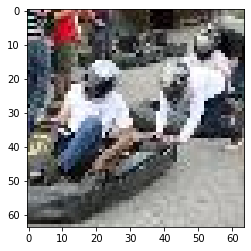

In [31]:
image, _, image_path = imagenet_val[0]
print(f"Sample image path:\n\t{image_path}")

def show(image, axis=None):
    numpy_image = image.cpu().numpy()
    if axis is None:
        plt.imshow(np.transpose(numpy_image, (1,2,0)))
    else:
        axis.imshow(np.transpose(numpy_image, (1,2,0)))

show(image)

## Algorithm

### Pre-trained ResNet-50

In [32]:
# Load Pretrained ResNet-50 from ImageNet
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)
model.fc = nn.Identity()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### PCA Algorithm

### Search Algorithm

In [49]:
def cosine_similarity(a: torch.Tensor, b: torch.Tensor):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def similarity_metric(target, embedding):
    vector, path = embedding
    return euclidean_distance(target, vector), path

def get_closest_match(target_image, embeddings):
    target_image_transformed = target_image.unsqueeze(0).to(device)
    target_embedding = model(target_image_transformed).squeeze(0).cpu().detach().numpy()
    
    similarity = map(lambda x: similarity_metric(target_embedding, x), embeddings)
    return sorted(similarity, key=itemgetter(0), reverse=False)

## Evaluation

In [44]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Create Embeddings Database

In [45]:
embeddings_database = list()

for images, _, paths in tqdm.tqdm(loader_database, unit="batch"):
    images = images.to(device)
    embeddings = model(images).cpu().detach().numpy()
    embeddings_database.extend(list(zip(embeddings, paths)))

100%|██████████| 155/155 [00:54<00:00,  2.86batch/s]


In [46]:
test_embedding, test_path = embeddings_database[0]
print(test_embedding.shape, test_path)

(2048,) /datasets/tiny-imagenet-200/test/images/test_6091.JPEG


### Test model output

Similarity: 0.30854111909866333
Similarity: 28.484485626220703
Similarity: 29.732336044311523
Similarity: 30.480764389038086


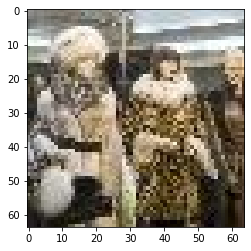

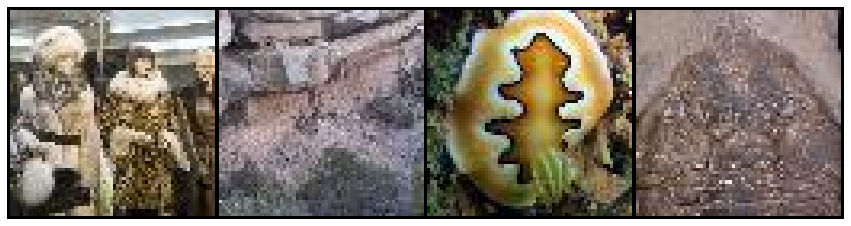

In [55]:
target, _, _ = random.choice(loader_database.dataset)
results = get_closest_match(target, embeddings_database)

figure, axis = plt.subplots()
show(target, axis=axis)

samples = list()

for similarity, path in results[:4]:
    print(f"Similarity: {similarity}")
    image = Image.open(path)
    samples.append(transform(image).unsqueeze(0).cpu())

samples = torch.vstack(samples)
samples = make_grid(samples, nrow=4, padding=1, normalize=False,
                    range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(samples)

### t-SNE Results

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[[-1.6144004  -0.529029  ]
 [ 0.14132811  1.7234823 ]
 [-1.8809956   5.320417  ]
 ...
 [-1.9127983  -3.3332036 ]
 [ 0.6458103   0.31287733]
 [ 0.21937864 -0.24105115]]


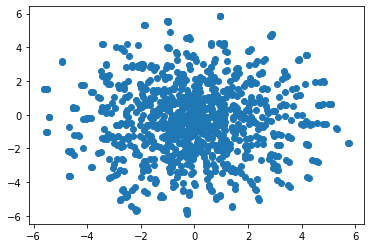

In [48]:
test_dataloader = DataLoader(imagenet_test, 1000, shuffle=False)
images, labels, _ = next(iter(test_dataloader))

z = model(images.to(device)).cpu().detach().numpy()
z_reduced = TSNE(init="pca", learning_rate="auto").fit_transform(z)

print(z_reduced)
z_reduced_x, z_reduced_y = zip(*z_reduced)

figure, axis = plt.subplots()

axis.scatter(list(z_reduced_x), list(z_reduced_y))